In [ ]:
# !pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

stock_filepath = os.getenv('HOME') +'/aiffel/aiffel_quest/mini_quest_240229/data/'
df = pd.read_csv(stock_filepath + '005930.KS.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [2]:
df = pd.read_csv(stock_filepath + '005930.KS.csv', index_col='Date', parse_dates=True)

ts_close =df['Close']
ts_close.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 시계열 안정성 정성적 분석

In [3]:
ts_close = ts_close.interpolate(method='time')
ts_close[ts_close.isna()]

Series([], Name: Close, dtype: float64)

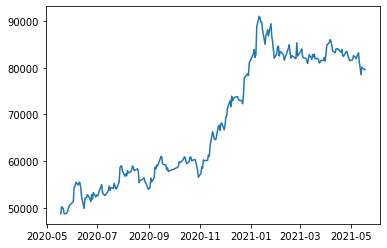

In [4]:
plt.plot(ts_close)

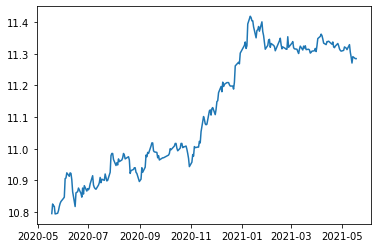

In [5]:
ts_log = np.log(ts_close)
plt.plot(ts_log)

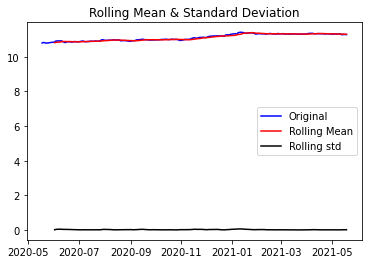

Results of Dickey=Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


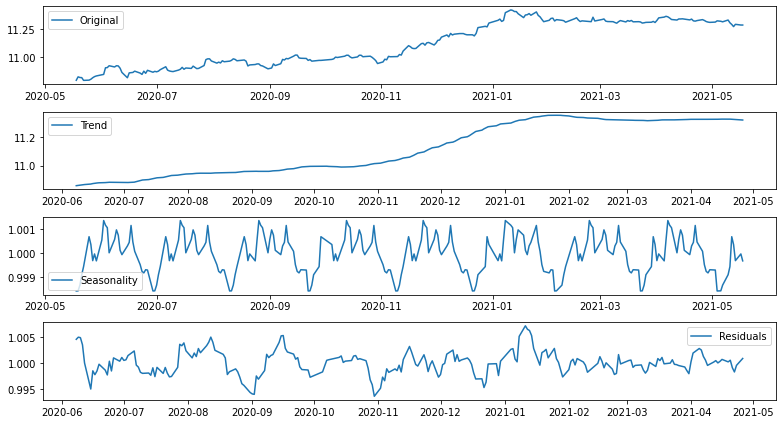

In [6]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)



from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

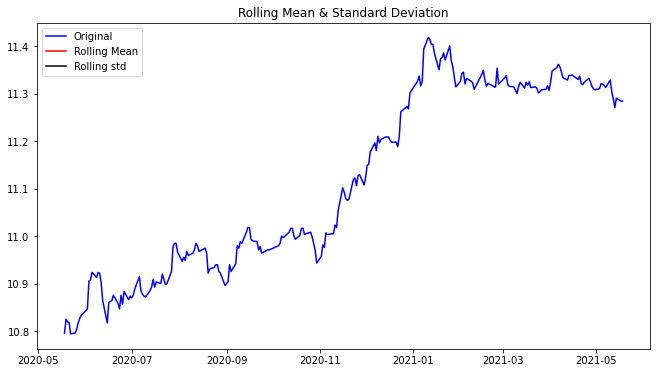

In [7]:
plot_rolling_statistics(ts_log, window=365)

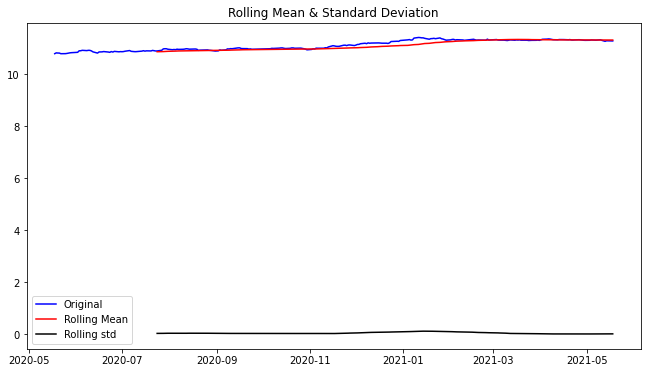

In [8]:
plot_rolling_statistics(ts_log, window=50)

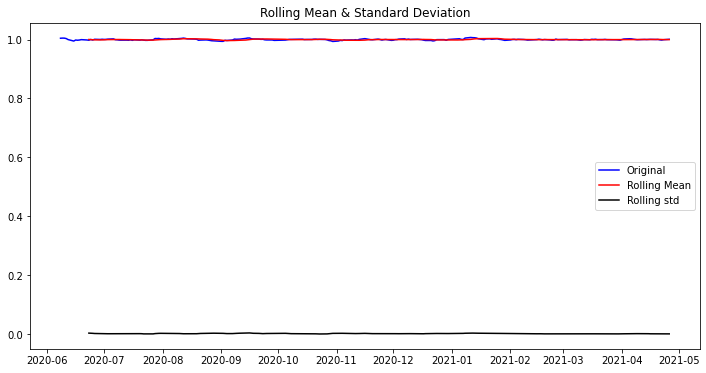

In [9]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (12, 6)
plot_rolling_statistics(residual)

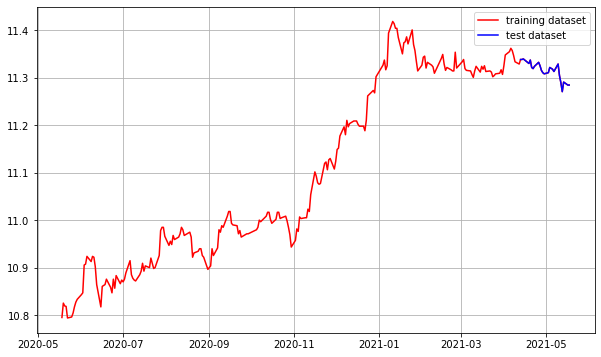

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

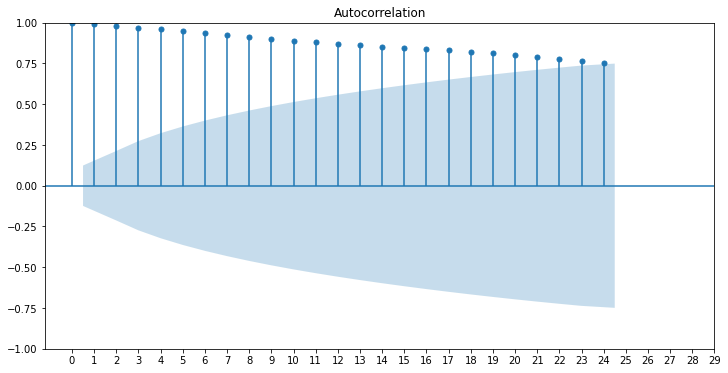

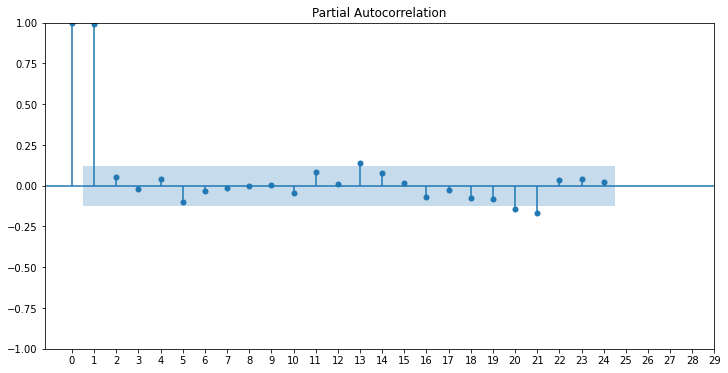

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plt.xticks(range(0, 30, 1))
plot_pacf(ts_log)
plt.xticks(range(0, 30, 1))
plt.show()

Results of Dickey=Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey=Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


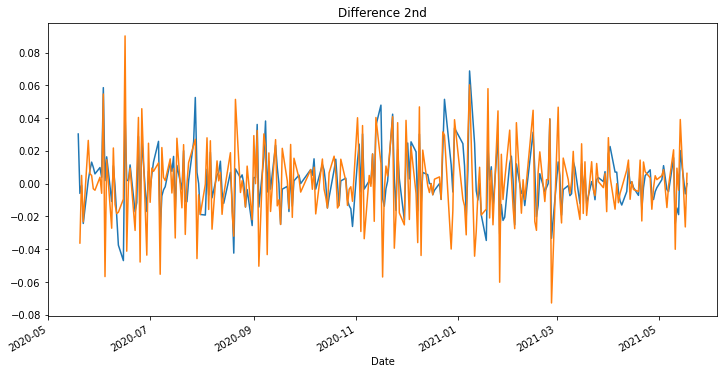

In [12]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 추세 상쇄하기

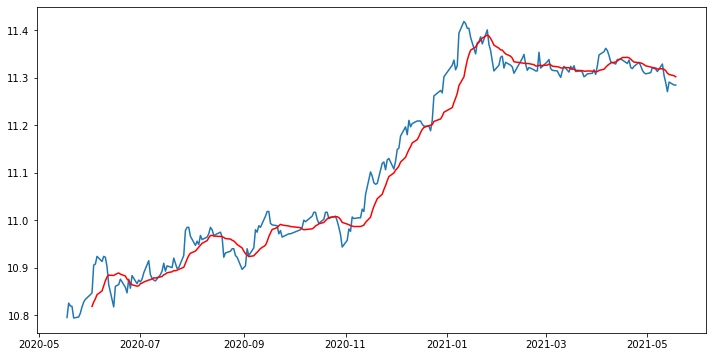

In [13]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [14]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
Name: Close, dtype: float64

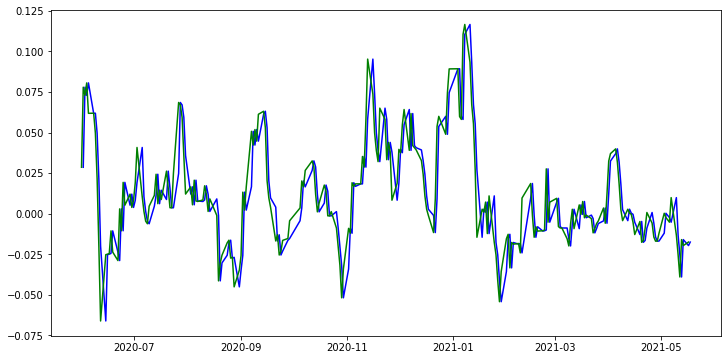

In [15]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

In [16]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
2020-06-23   -0.028907
2020-06-24    0.002950
2020-06-25   -0.010546
2020-06-26    0.019292
2020-06-29    0.005231
Name: Close, dtype: float64

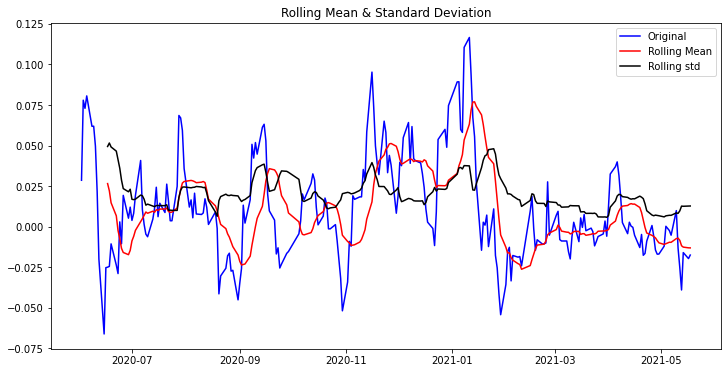

In [17]:
plot_rolling_statistics(ts_log_moving_avg)

In [18]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [19]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

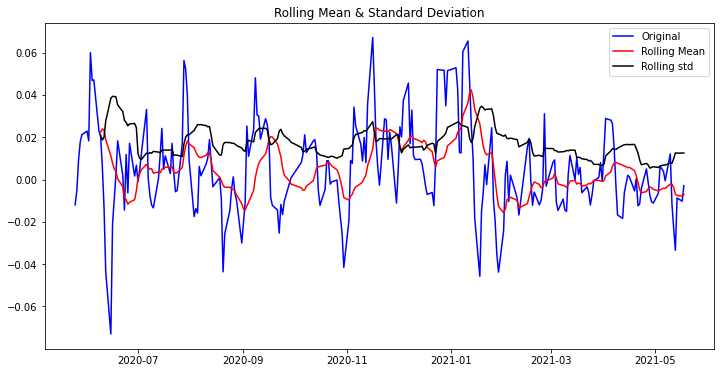

In [20]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey=Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


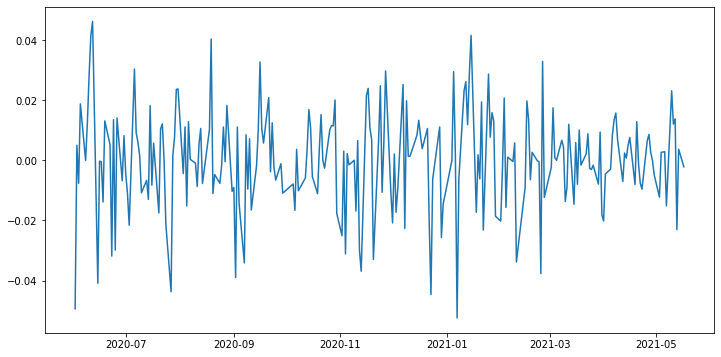

In [22]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [23]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Sun, 03 Mar 2024   AIC                          -1156.722
Time:                        14:11:27   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

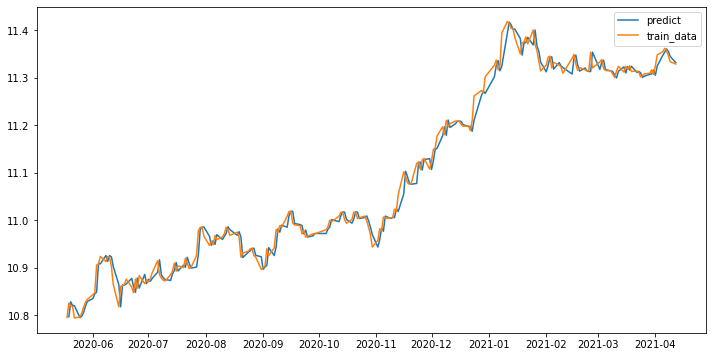

In [24]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

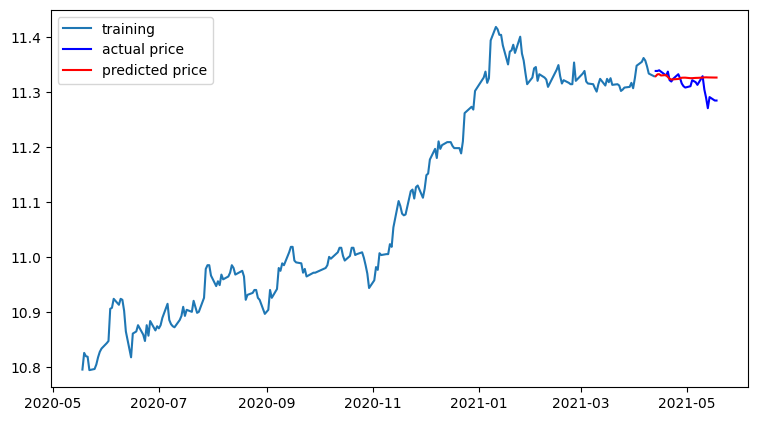

In [25]:
model = ARIMA(train_data, order=(14,1,0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3005069.905300547
MAE:  1233.7924909538601
RMSE:  1733.5137453451434
MAPE: 1.53%


### 삼성주가_최근 주가 포함 

In [27]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
samsung_electronics = yf.Ticker('005930.KS')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.

# 시작일과 종료일 설정 (2020년 1월 1일부터 2024년 1월 31일까지)
start_date = '2000-01-01'
end_date = '2024-02-27'

# 데이터 가져오기 (과거부터 오늘까지의 데이터)
samsung_data = samsung_electronics.history(start=start_date, end=end_date)


# 날짜 형식 변경 및 인덱스 설정
samsung_data.index = pd.to_datetime(samsung_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(samsung_data,  columns=samsung_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-04,4389.457281,4469.930664,4140.721368,4469.930664,74195000,0.0,0.0
2000-01-05,4243.143350,4433.353224,4038.301947,4082.196533,74680000,0.0,0.0
2000-01-06,4206.565406,4228.512704,4082.197386,4111.460449,54390000,0.0,0.0
2000-01-07,4067.564633,4148.038034,3921.249358,4052.933105,40305000,0.0,0.0
2000-01-10,4096.827814,4221.195801,4082.196286,4221.195801,46880000,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-20,73700.000000,73700.000000,72800.000000,73300.000000,14681477,0.0,0.0
2024-02-21,73400.000000,73700.000000,72900.000000,73000.000000,11503495,0.0,0.0
2024-02-22,73800.000000,73900.000000,72700.000000,73100.000000,15208934,0.0,0.0


In [28]:
ts = df['Close']
ts

Date
2000-01-04     4469.930664
2000-01-05     4082.196533
2000-01-06     4111.460449
2000-01-07     4052.933105
2000-01-10     4221.195801
                  ...     
2024-02-20    73300.000000
2024-02-21    73000.000000
2024-02-22    73100.000000
2024-02-23    72900.000000
2024-02-26    72800.000000
Name: Close, Length: 6055, dtype: float64

In [29]:
ts = ts.interpolate(method='time')
# ts[ts.isna()]

In [30]:
ts.fillna(0)

Date
2000-01-04     4469.930664
2000-01-05     4082.196533
2000-01-06     4111.460449
2000-01-07     4052.933105
2000-01-10     4221.195801
                  ...     
2024-02-20    73300.000000
2024-02-21    73000.000000
2024-02-22    73100.000000
2024-02-23    72900.000000
2024-02-26    72800.000000
Name: Close, Length: 6055, dtype: float64

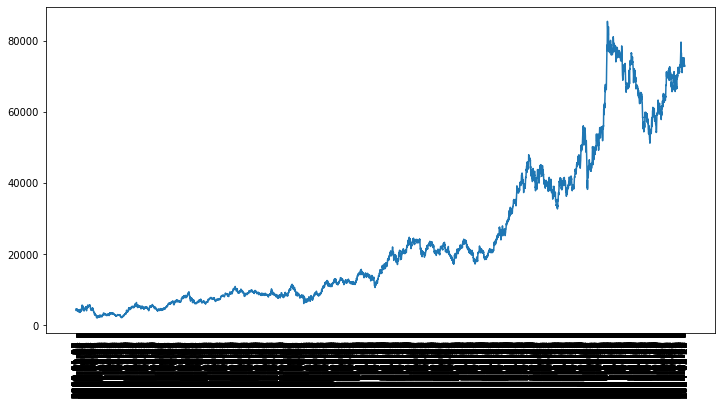

In [31]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

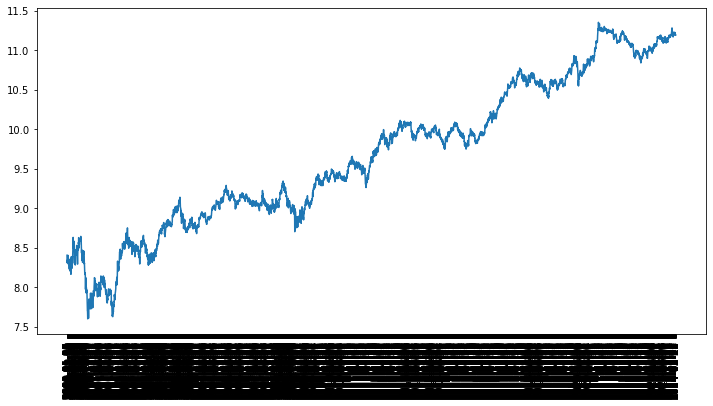

In [32]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [33]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [34]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

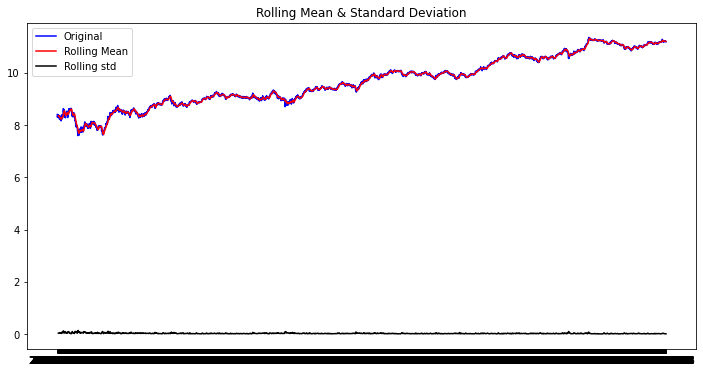

Results of Dickey=Fuller Test:
Test Statistic                   -0.591387
p-value                           0.872916
#Lags Used                        4.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


In [35]:
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

계절성 추세 확인하기

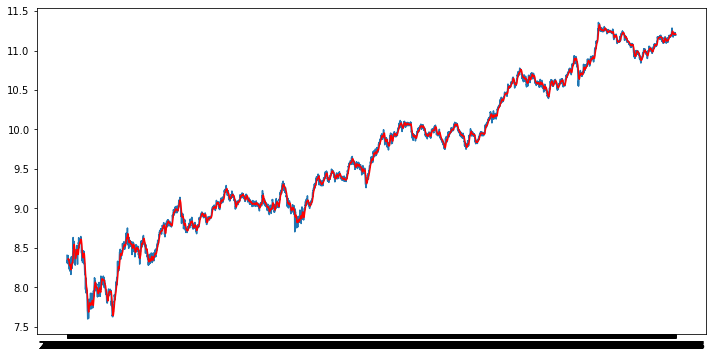

In [36]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [37]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12         NaN
2000-01-13         NaN
2000-01-14         NaN
2000-01-17         NaN
2000-01-18         NaN
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007849
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057965
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
Name: Close, dtype: float64

In [38]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007849
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057965
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
2000-02-01   -0.075802
2000-02-02   -0.076542
2000-02-03   -0.085232
2000-02-04   -0.072735
2000-02-07   -0.039679
2000-02-08    0.002573
2000-02-09    0.054311
2000-02-10    0.056517
2000-02-11    0.042765
2000-02-14   -0.012872
2000-02-15   -0.037515
Name: Close, dtype: float64

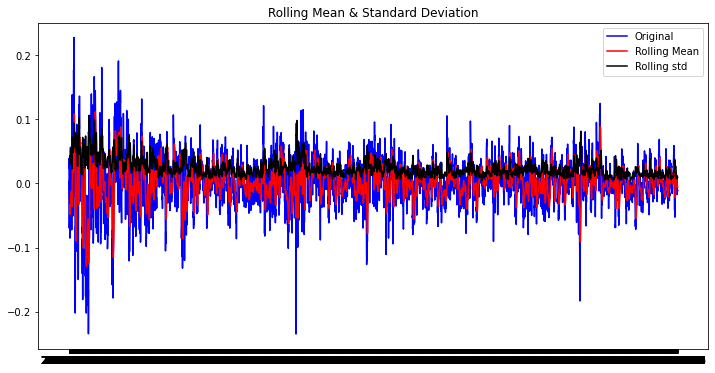

In [39]:
plot_rolling_statistics(ts_log_moving_avg)

In [40]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -1.771015e+01
p-value                        3.505233e-30
#Lags Used                     1.100000e+01
Number of Observations Used    6.032000e+03
Critical Value (1%)           -3.431435e+00
Critical Value (5%)           -2.862019e+00
Critical Value (10%)          -2.567025e+00
dtype: float64


p-valuer가 0.05 보다 작아서 유의수준임을 확인했음

차분(Differencing) - 계절성(Seasonality) 상쇄하기

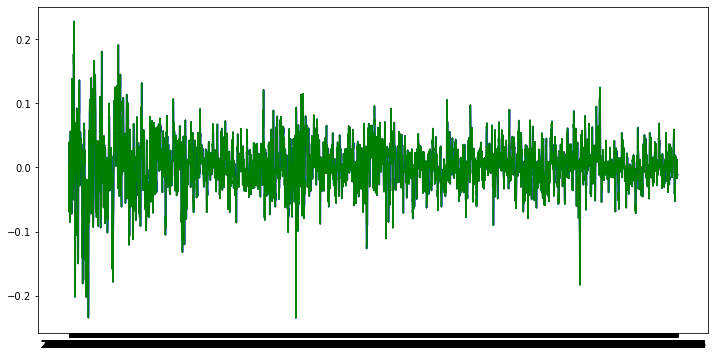

In [41]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

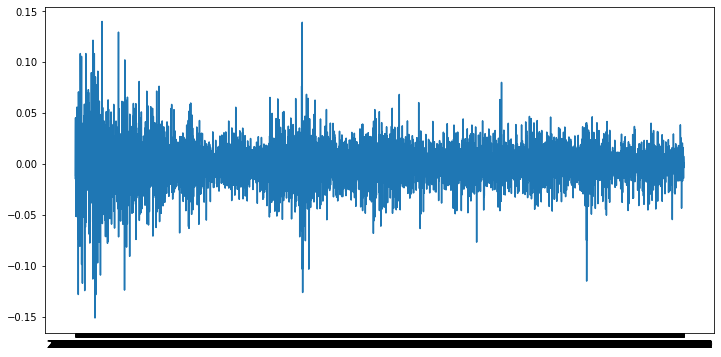

In [42]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

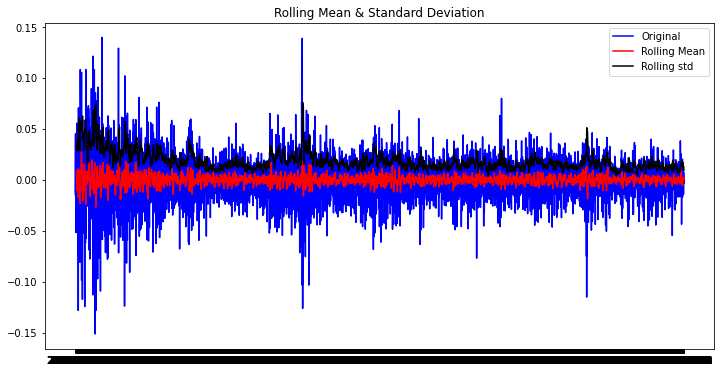

In [43]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [44]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                  -21.119136
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    6009.000000
Critical Value (1%)              -3.431439
Critical Value (5%)              -2.862021
Critical Value (10%)             -2.567026
dtype: float64


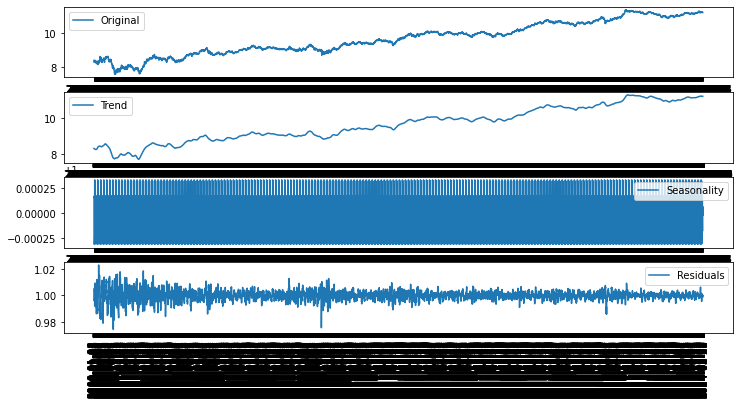

<Figure size 864x432 with 0 Axes>

In [45]:
# 시계열 분해 
from statsmodels.tsa.seasonal import seasonal_decompose
decompostition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decompostition.trend
seasonal = decompostition.seasonal
residual = decompostition.resid



plt.rcParams['figure.figsize'] = (12,6)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.xticks(rotation=90)

plt.show()

plt.tight_layout()

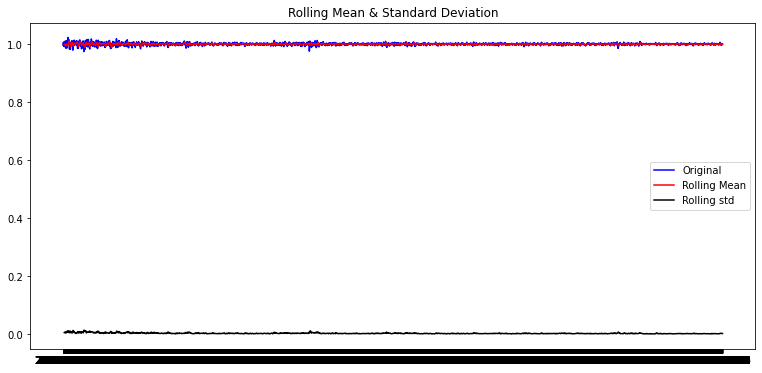

In [46]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [47]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                  -18.879083
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5991.000000
Critical Value (1%)              -3.431442
Critical Value (5%)              -2.862023
Critical Value (10%)             -2.567027
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                  -42.769262
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


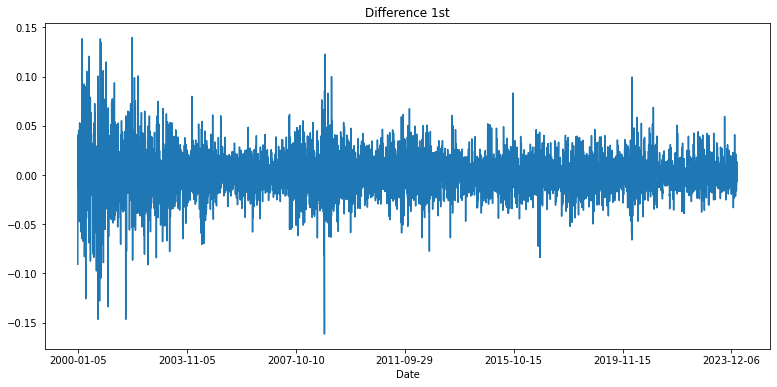

In [48]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                  -22.955014
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6018.000000
Critical Value (1%)              -3.431437
Critical Value (5%)              -2.862020
Critical Value (10%)             -2.567026
dtype: float64


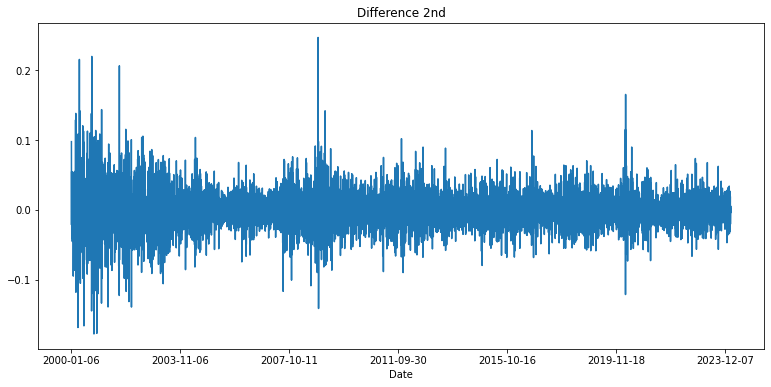

In [49]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

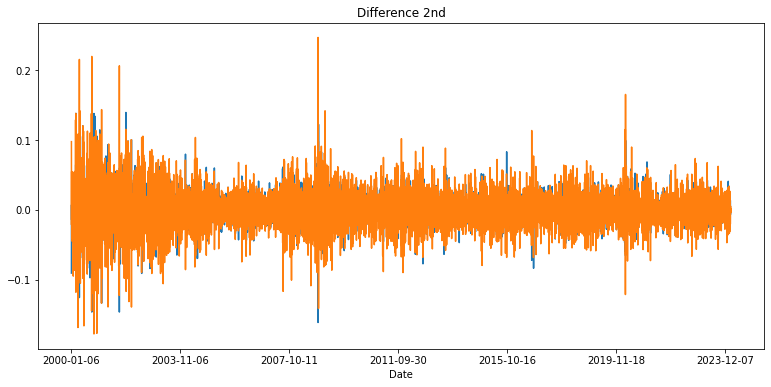

In [50]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

차분은 1차분으로해도 충분해 보임

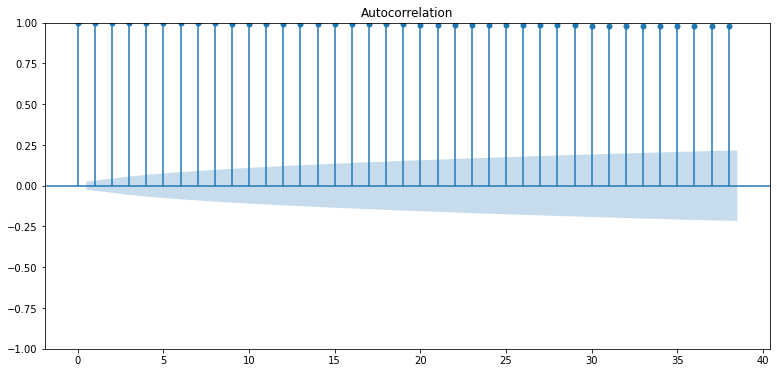

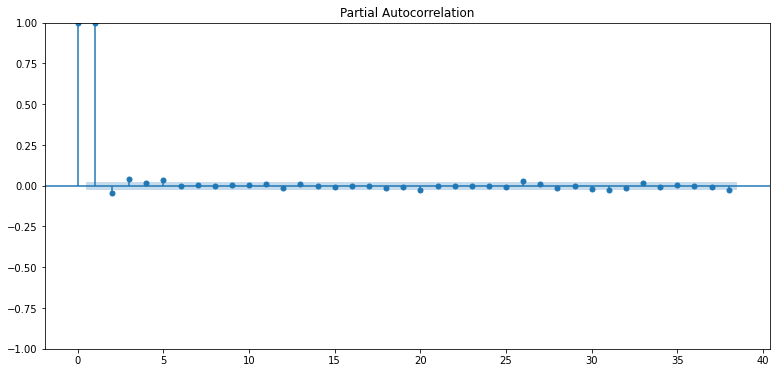

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

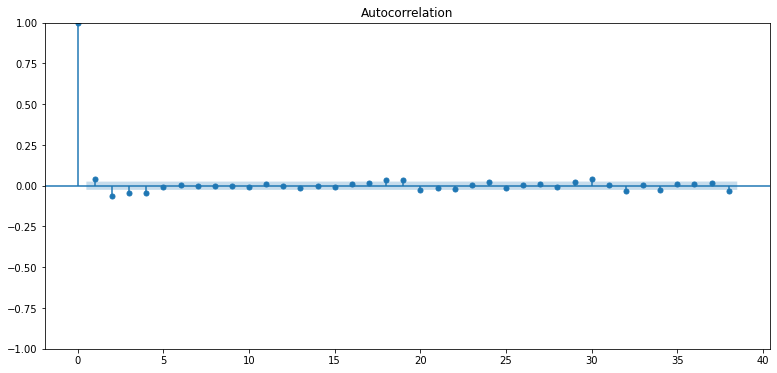

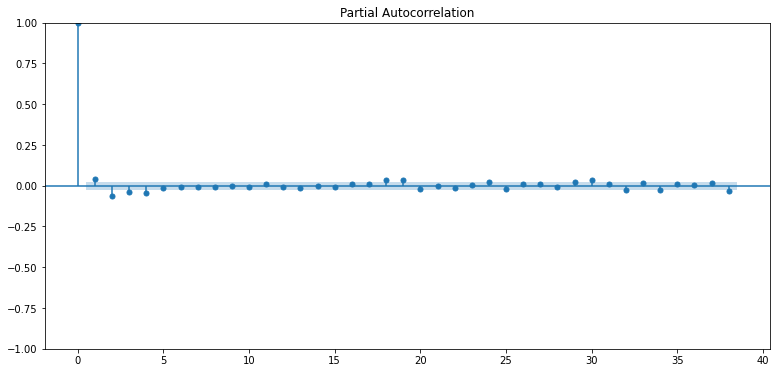

In [52]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

학습 데이터 분리

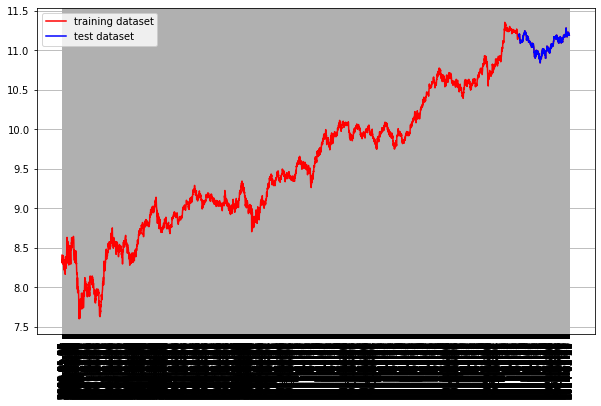

In [53]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

ARIMA의 모수는 3가지

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

p: 1 d:1 , q:0 으로 진행

 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

In [54]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(1, 1, 0)   Log Likelihood               12989.792
Date:                Sun, 03 Mar 2024   AIC                         -25975.584
Time:                        14:27:19   BIC                         -25962.378
Sample:                             0   HQIC                        -25970.976
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0416      0.009      4.493      0.000       0.023       0.060
sigma2         0.0005   5.23e-06     95.119      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

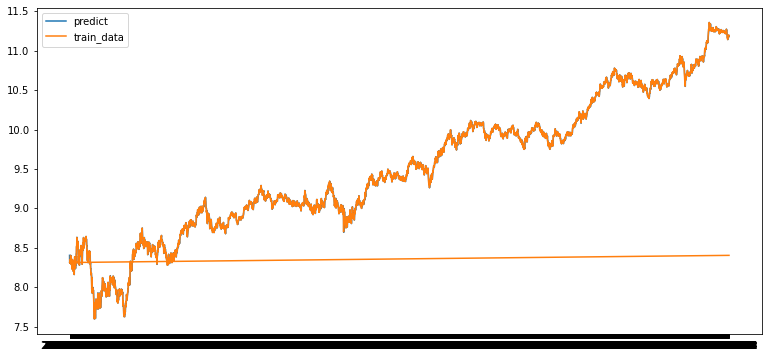

In [55]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

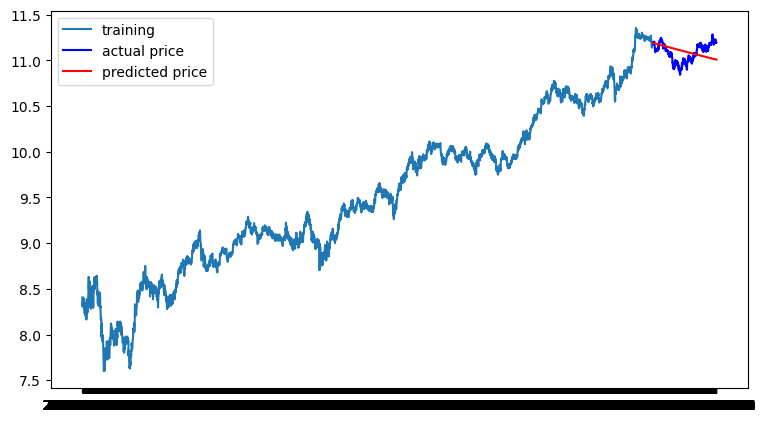

In [56]:
model = ARIMA(train_data, order=(1,0,1))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

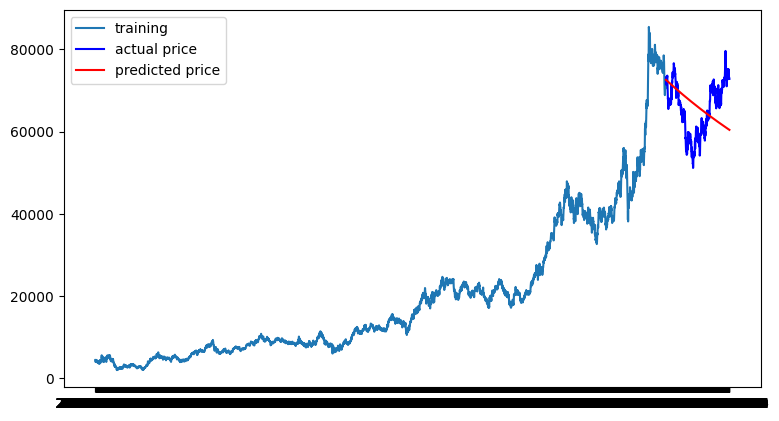

In [57]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  58580028.591981165
MAE:  6512.767263016969
RMSE:  7653.759115100315
MAPE: 10.19%


In [59]:
from statsmodels.tsa.arima.model import ARIMA
# 이동평균을 12 했을때 확인
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                ARIMA(0, 1, 12)   Log Likelihood               13011.385
Date:                Sun, 03 Mar 2024   AIC                         -25996.769
Time:                        14:30:44   BIC                         -25910.930
Sample:                             0   HQIC                        -25966.814
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0372      0.010      3.892      0.000       0.018       0.056
ma.L2         -0.0639      0.009     -6.735      0.000      -0.083      -0.045
ma.L3         -0.0384      0.010     -3.803      0.0

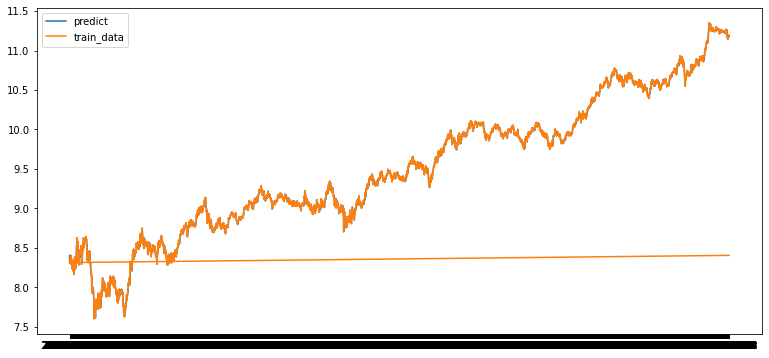

In [60]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

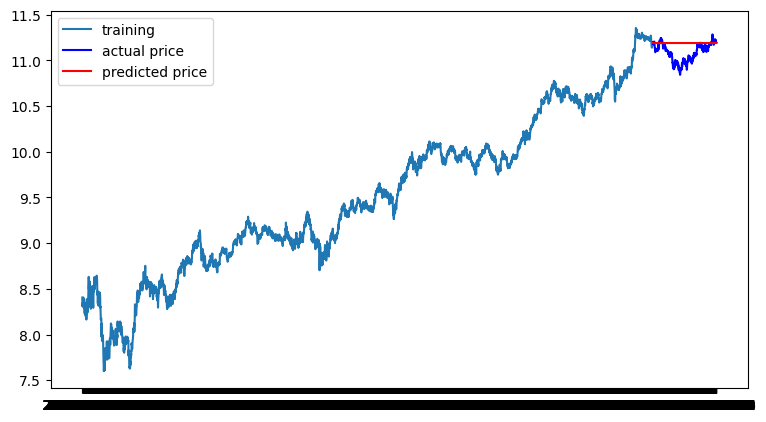

In [61]:
model = ARIMA(train_data, order=(0, 1, 12))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

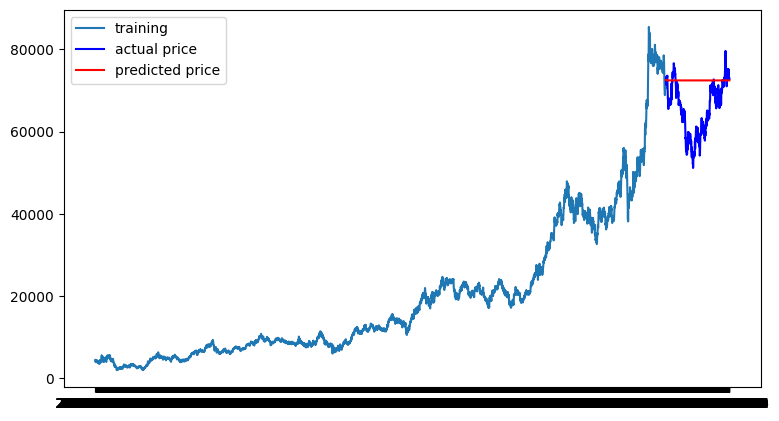

In [62]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  86863469.50231448
MAE:  7403.849766964657
RMSE:  9320.057376556997
MAPE: 12.25%


In [64]:
from statsmodels.tsa.arima.model import ARIMA
# 이동평균을 4 했을때 확인
model = ARIMA(train_data, order=(0, 1, 4))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(0, 1, 4)   Log Likelihood               13010.835
Date:                Sun, 03 Mar 2024   AIC                         -26011.669
Time:                        14:34:08   BIC                         -25978.654
Sample:                             0   HQIC                        -26000.148
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0400      0.009      4.272      0.000       0.022       0.058
ma.L2         -0.0634      0.009     -6.740      0.000      -0.082      -0.045
ma.L3         -0.0412      0.010     -4.186      0.0

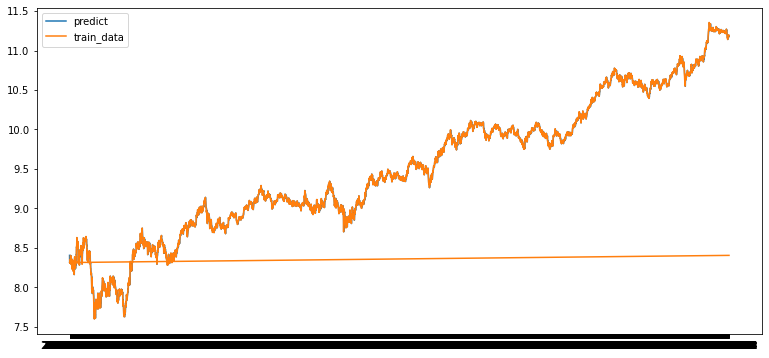

In [65]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

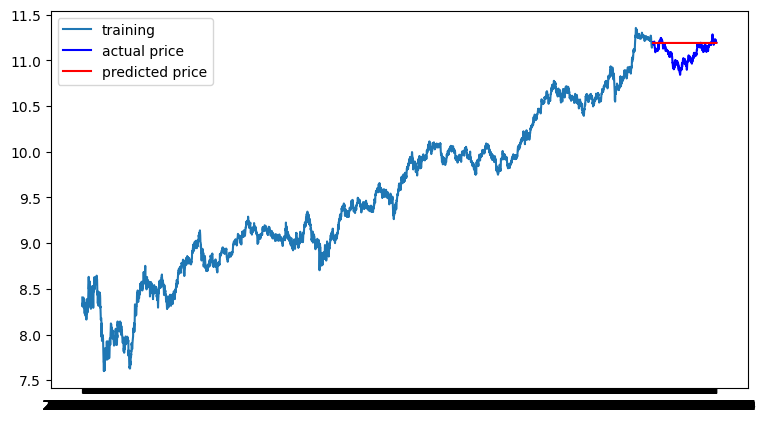

In [66]:
model = ARIMA(train_data, order=(0, 1, 4))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

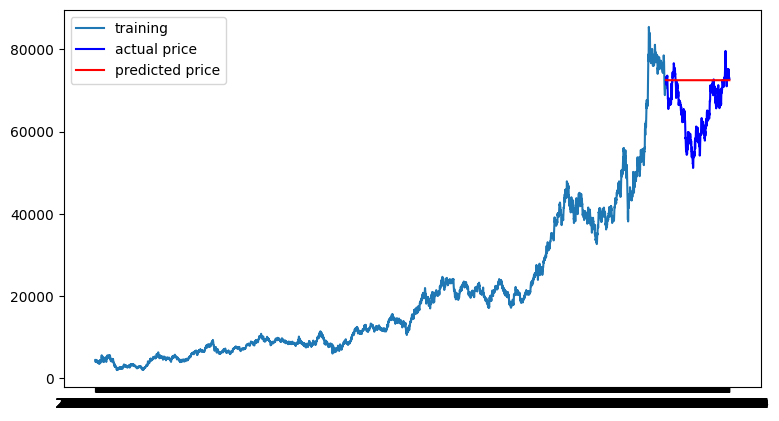

In [67]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  87538884.5935445
MAE:  7437.920710683791
RMSE:  9356.221705023054
MAPE: 12.30%


order=(1,0,1)) 가 가장 좋았다.

MSE:  58580021.85184506<br>
MAE:  6512.767548274643<br>
RMSE:  7653.758674784897<br>
MAPE: 10.19%

## 아이온큐

In [69]:
import yfinance as yf

ionq = yf.Ticker('IONQ')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
ionq_data = ionq.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
ionq_data.index = pd.to_datetime(ionq_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(ionq_data,  columns=ionq_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,11.125,11.250,10.50,10.80,150500,0.0,0.0
2021-01-05,10.850,11.830,10.75,11.11,165300,0.0,0.0
2021-01-06,11.500,11.500,11.00,11.05,175600,0.0,0.0
2021-01-07,11.500,11.500,11.05,11.11,94200,0.0,0.0
2021-01-08,11.650,12.350,11.00,11.01,137500,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-26,10.820,11.300,10.77,11.24,6379300,0.0,0.0
2024-02-27,11.430,11.676,11.24,11.57,7447000,0.0,0.0
2024-02-28,11.300,11.629,11.16,11.26,12725100,0.0,0.0


In [70]:
ts = df['Close']
ts

Date
2021-01-04    10.80
2021-01-05    11.11
2021-01-06    11.05
2021-01-07    11.11
2021-01-08    11.01
              ...  
2024-02-26    11.24
2024-02-27    11.57
2024-02-28    11.26
2024-02-29    10.36
2024-03-01    10.66
Name: Close, Length: 795, dtype: float64

In [71]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

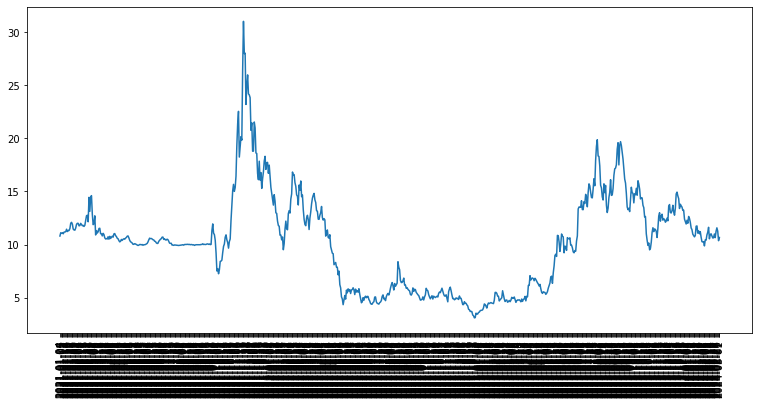

In [72]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

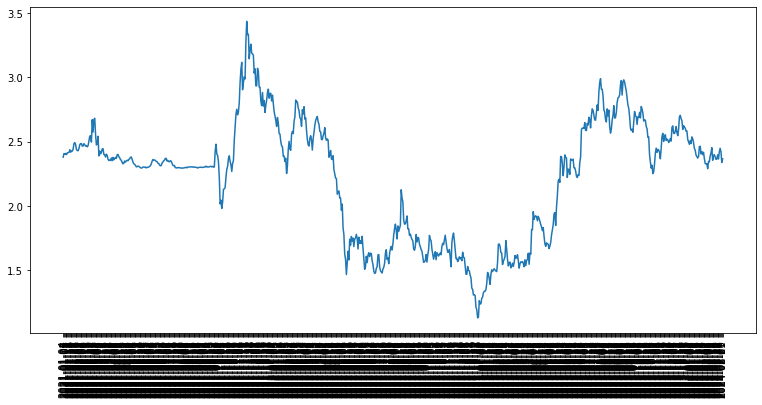

In [73]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

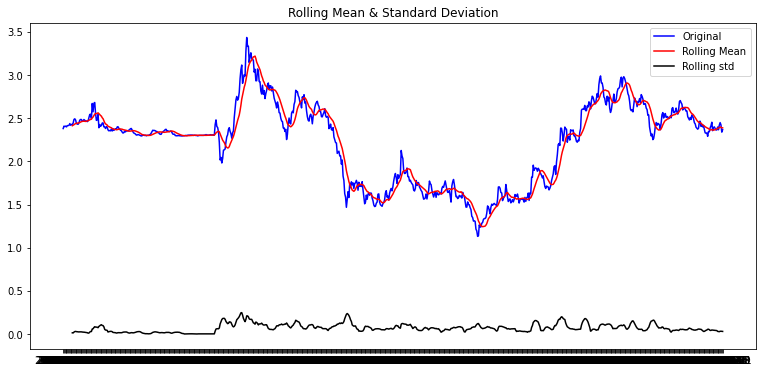

In [74]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [75]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey=Fuller Test:
Test Statistic                  -1.825774
p-value                          0.367743
#Lags Used                      16.000000
Number of Observations Used    778.000000
Critical Value (1%)             -3.438783
Critical Value (5%)             -2.865262
Critical Value (10%)            -2.568752
dtype: float64


계절성 추세 확인하기

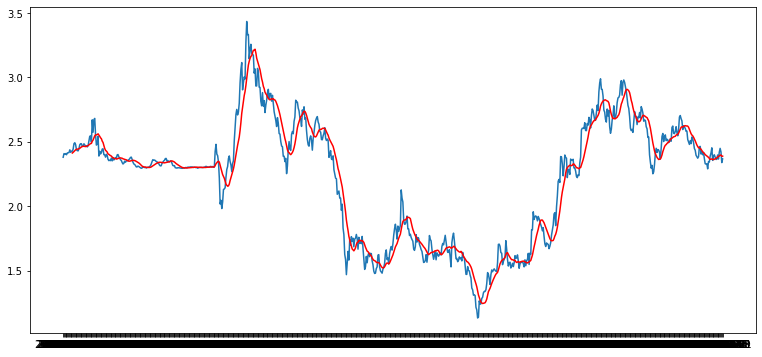

In [76]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [77]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2021-01-04         NaN
2021-01-05         NaN
2021-01-06         NaN
2021-01-07         NaN
2021-01-08         NaN
2021-01-11         NaN
2021-01-12         NaN
2021-01-13         NaN
2021-01-14         NaN
2021-01-15         NaN
2021-01-19         NaN
2021-01-20    0.014263
2021-01-21    0.024805
2021-01-22    0.060943
2021-01-25    0.060920
2021-01-26    0.040125
2021-01-27   -0.002529
2021-01-28   -0.011020
2021-01-29   -0.014038
2021-02-01    0.000866
Name: Close, dtype: float64

In [78]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2021-01-20    0.014263
2021-01-21    0.024805
2021-01-22    0.060943
2021-01-25    0.060920
2021-01-26    0.040125
2021-01-27   -0.002529
2021-01-28   -0.011020
2021-01-29   -0.014038
2021-02-01    0.000866
2021-02-02    0.027433
2021-02-03    0.030201
2021-02-04    0.024575
2021-02-05    0.002029
2021-02-08    0.001723
2021-02-09    0.019462
2021-02-10    0.011706
2021-02-11    0.003389
2021-02-12    0.003425
2021-02-16   -0.007470
2021-02-17   -0.001422
Name: Close, dtype: float64

In [ ]:
plot_rolling_statistics(ts_log_moving_avg)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg)

p-valuer가 0.05 보다 작아서 유의수준임을 확인했음

차분(Differencing) - 계절성(Seasonality) 상쇄하기

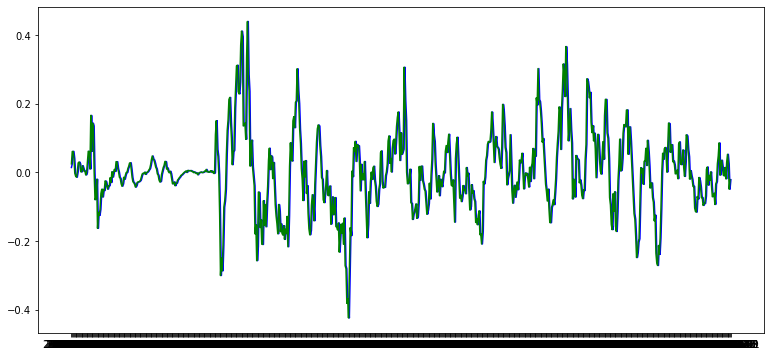

In [81]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

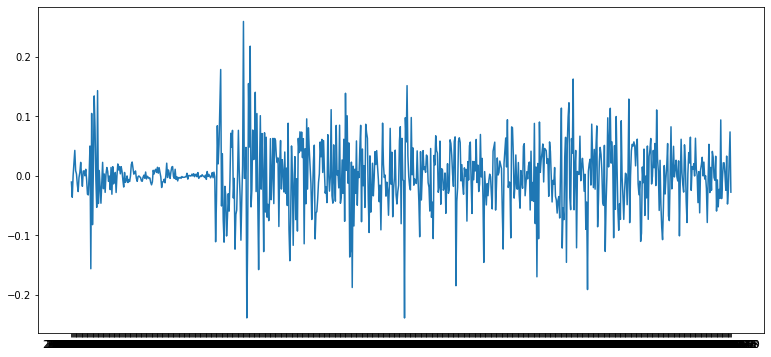

In [82]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

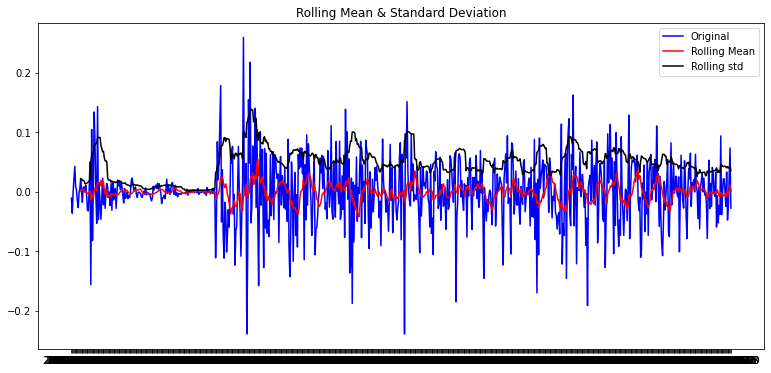

In [83]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [84]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                -1.046558e+01
p-value                        1.324405e-18
#Lags Used                     1.800000e+01
Number of Observations Used    7.640000e+02
Critical Value (1%)           -3.438938e+00
Critical Value (5%)           -2.865330e+00
Critical Value (10%)          -2.568788e+00
dtype: float64


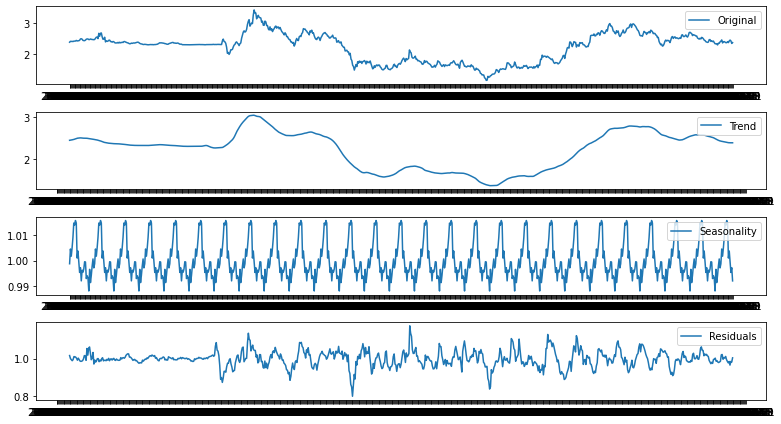

In [85]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

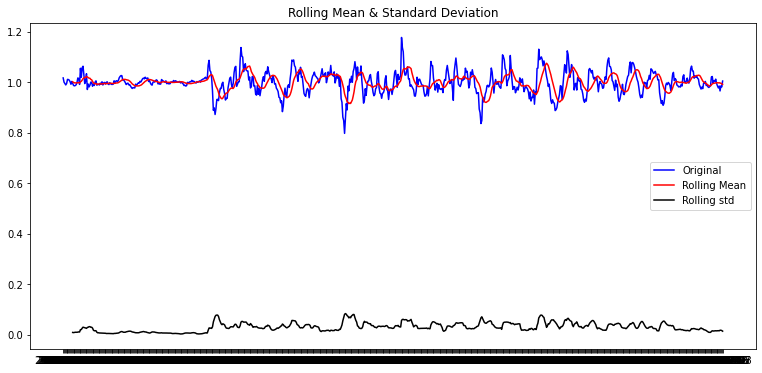

In [86]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [87]:
augmented_dickey_fuller_test(residual)

Results of Dickey=Fuller Test:
Test Statistic                -9.816654e+00
p-value                        5.474916e-17
#Lags Used                     1.400000e+01
Number of Observations Used    7.500000e+02
Critical Value (1%)           -3.439099e+00
Critical Value (5%)           -2.865401e+00
Critical Value (10%)          -2.568826e+00
dtype: float64


Results of Dickey=Fuller Test:
Test Statistic                -7.195309e+00
p-value                        2.443374e-10
#Lags Used                     1.500000e+01
Number of Observations Used    7.780000e+02
Critical Value (1%)           -3.438783e+00
Critical Value (5%)           -2.865262e+00
Critical Value (10%)          -2.568752e+00
dtype: float64


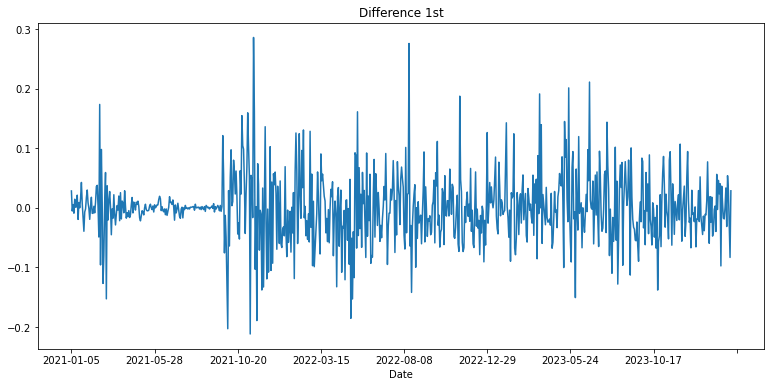

In [88]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)      

Results of Dickey=Fuller Test:
Test Statistic                -1.016878e+01
p-value                        7.181102e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.720000e+02
Critical Value (1%)           -3.438849e+00
Critical Value (5%)           -2.865291e+00
Critical Value (10%)          -2.568767e+00
dtype: float64


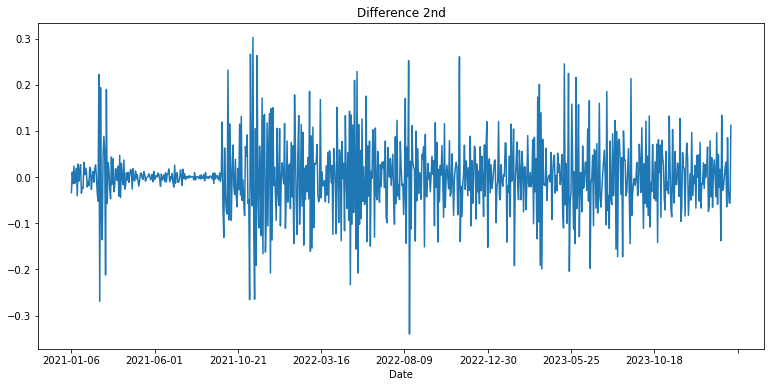

In [89]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

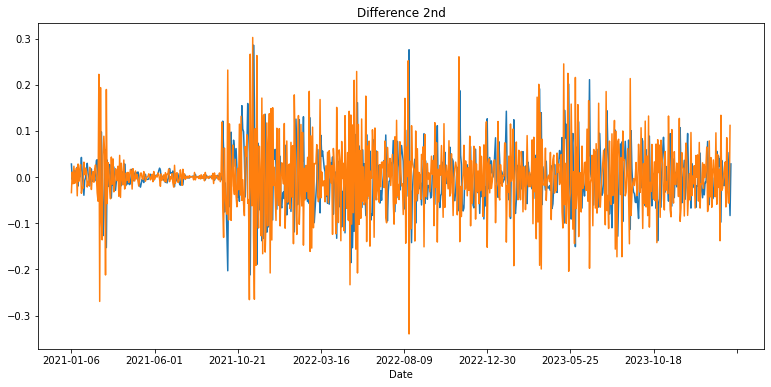

In [90]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

1차분 충분해 보임

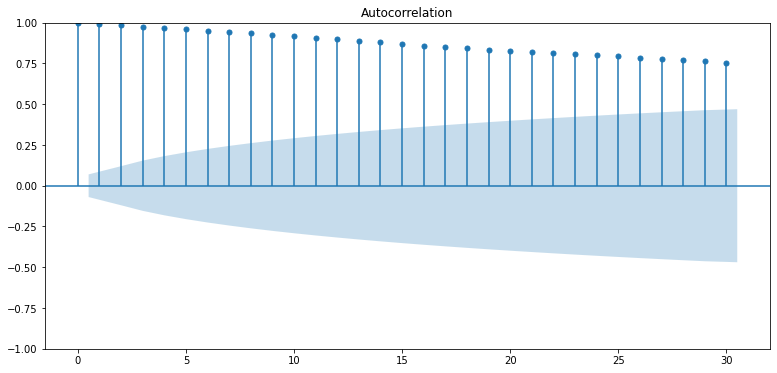

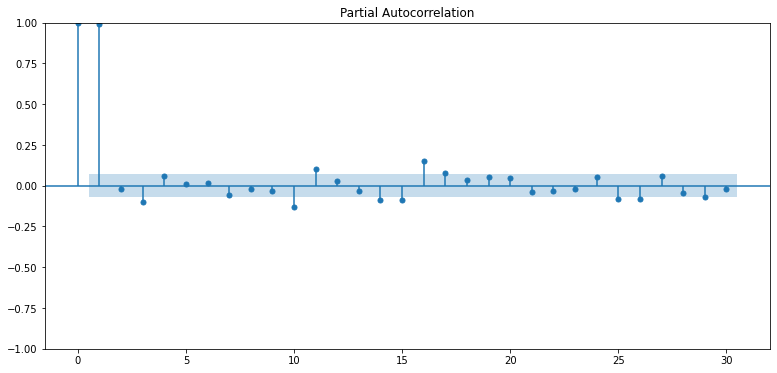

In [91]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

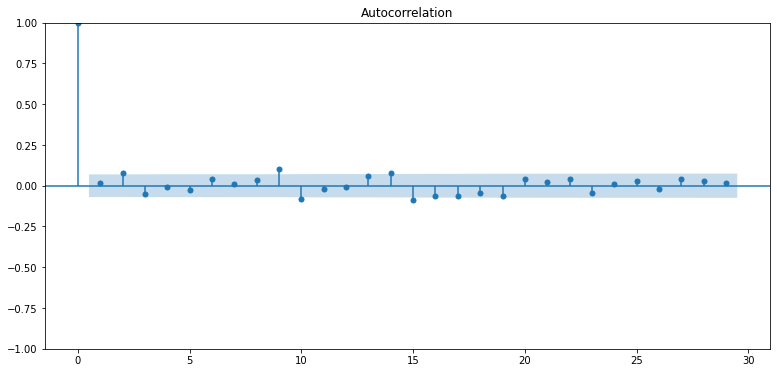

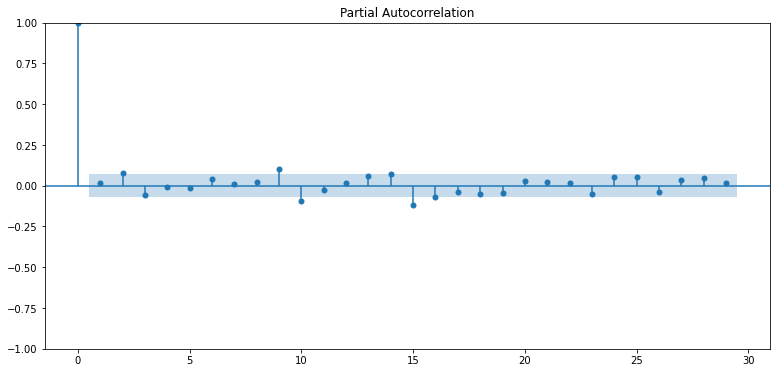

In [92]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

q,p값이 1~2 적합하게 보임

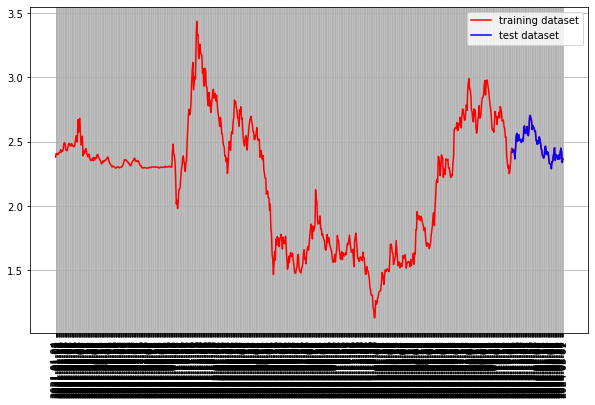

In [93]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

p: 2 d:1 , q:0 으로 진행

 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문

In [94]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  715
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1032.996
Date:                Sun, 03 Mar 2024   AIC                          -2059.991
Time:                        14:39:38   BIC                          -2046.279
Sample:                             0   HQIC                         -2054.695
                                - 715                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.032      0.547      0.584      -0.045       0.080
ar.L2          0.0898      0.029      3.053      0.002       0.032       0.147
sigma2         0.0032      0.000     28.741      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


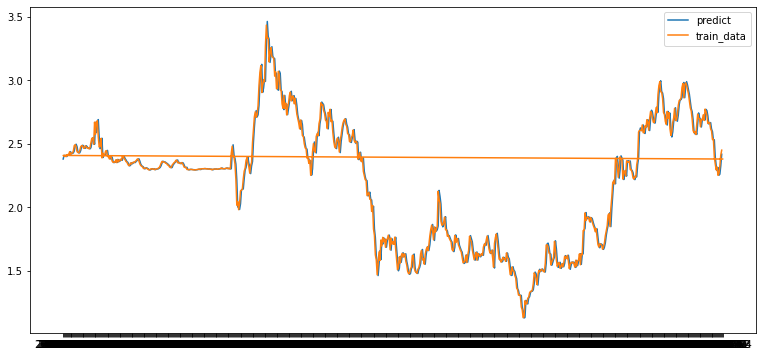

In [95]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

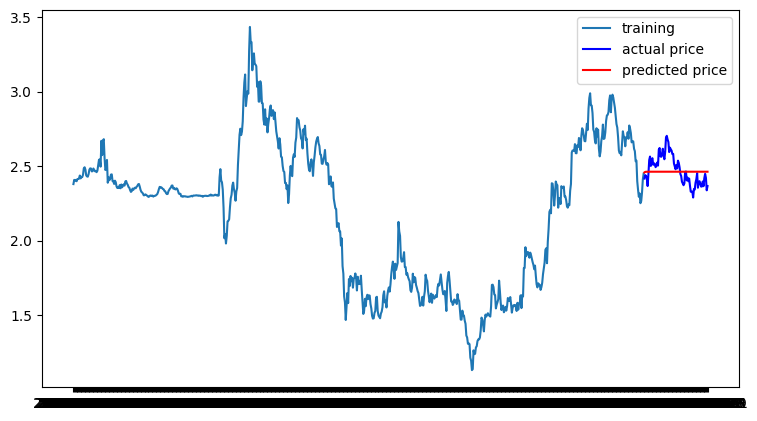

In [96]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

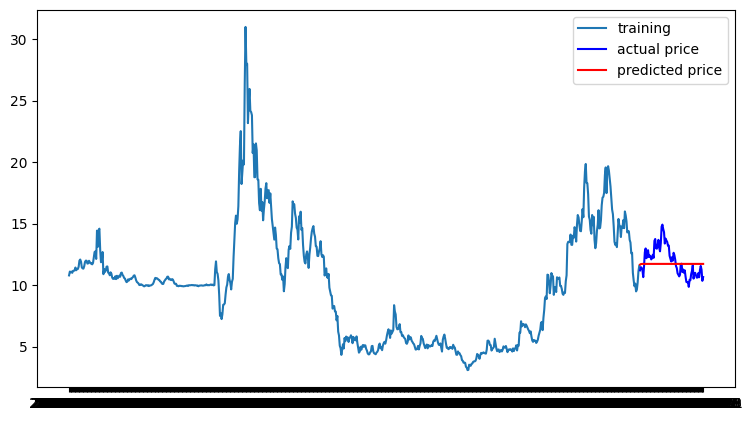

In [97]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1.4709028598339136
MAE:  1.0081257475753567
RMSE:  1.2128078412650183
MAPE: 8.28%


(2, 1, 0)이 MAPE값 낮게 나옴

MSE:  1.4709028598339136
MAE:  1.0081257475753567
RMSE:  1.2128078412650183
MAPE: 8.28%

## 코닝

In [99]:
import yfinance as yf


cornings = yf.Ticker('GLW')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cornings_data = cornings.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
cornings_data.index = pd.to_datetime(cornings_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cornings_data,  columns=cornings_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1981-12-31,0.798927,0.801818,0.796036,0.799890,674400,0.00,0.0
1982-01-04,0.803746,0.809528,0.796036,0.801818,914400,0.00,0.0
1982-01-05,0.796036,0.799891,0.792181,0.796036,876000,0.00,0.0
1982-01-06,0.786399,0.792181,0.778689,0.780617,770400,0.00,0.0
1982-01-07,0.763269,0.774834,0.749777,0.751704,1250400,0.00,0.0
...,...,...,...,...,...,...,...
2024-02-26,32.328448,32.487066,32.229309,32.229309,4089800,0.00,0.0
2024-02-27,32.378015,32.477150,32.060778,32.150002,2533800,0.00,0.0
2024-02-28,32.029999,32.220001,31.809999,32.090000,3000400,0.28,0.0


In [100]:
ts = df['Close']
ts

Date
1981-12-31     0.799890
1982-01-04     0.801818
1982-01-05     0.796036
1982-01-06     0.780617
1982-01-07     0.751704
                ...    
2024-02-26    32.229309
2024-02-27    32.150002
2024-02-28    32.090000
2024-02-29    32.240002
2024-03-01    32.450001
Name: Close, Length: 10630, dtype: float64

In [101]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

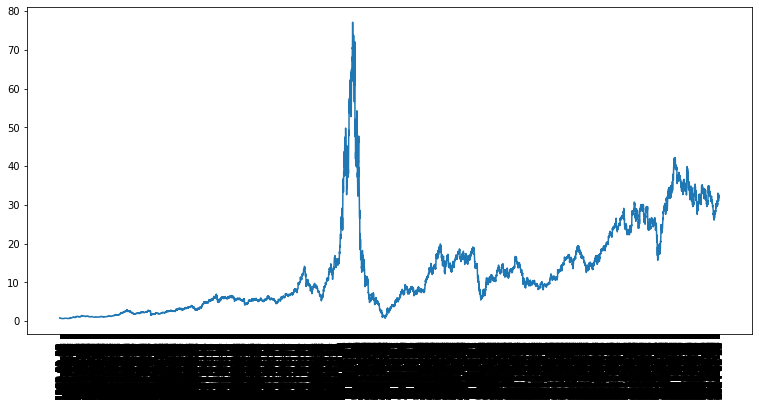

In [102]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

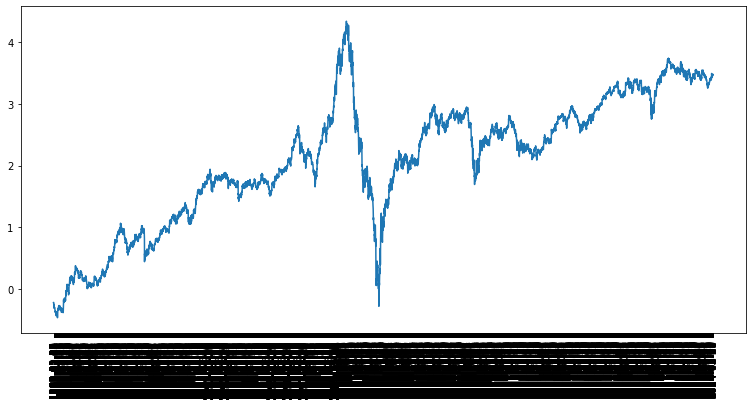

In [103]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

구간 통계치(Rolling Statistics)를 시각화 & 검정을 통해 정상성 확인하기

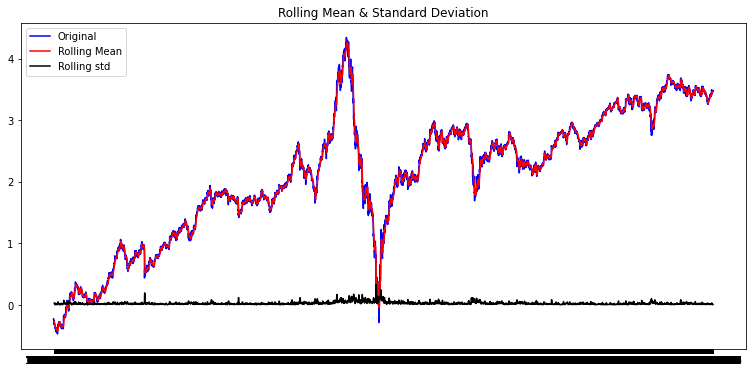

In [104]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [105]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


Results of Dickey=Fuller Test:
Test Statistic                    -2.184492
p-value                            0.211922
#Lags Used                        39.000000
Number of Observations Used    10590.000000
Critical Value (1%)               -3.430968
Critical Value (5%)               -2.861813
Critical Value (10%)              -2.566915
dtype: float64


계절성 추세 확인하기

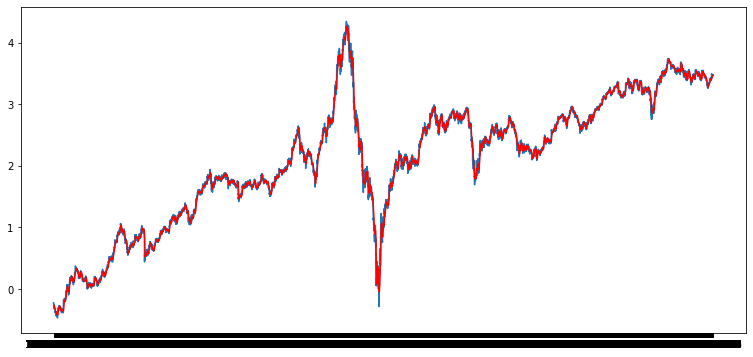

In [106]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [107]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
1981-12-31         NaN
1982-01-04         NaN
1982-01-05         NaN
1982-01-06         NaN
1982-01-07         NaN
1982-01-08         NaN
1982-01-11         NaN
1982-01-12         NaN
1982-01-13         NaN
1982-01-14         NaN
1982-01-15         NaN
1982-01-18   -0.024571
1982-01-19   -0.030855
1982-01-20   -0.033592
1982-01-21   -0.026432
1982-01-22   -0.016078
1982-01-25   -0.016542
1982-01-26   -0.004229
1982-01-27   -0.006247
1982-01-28   -0.003240
Name: Close, dtype: float64

In [108]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
1982-01-18   -0.024571
1982-01-19   -0.030855
1982-01-20   -0.033592
1982-01-21   -0.026432
1982-01-22   -0.016078
1982-01-25   -0.016542
1982-01-26   -0.004229
1982-01-27   -0.006247
1982-01-28   -0.003240
1982-01-29   -0.003918
1982-02-01   -0.011403
1982-02-02   -0.019648
1982-02-03   -0.038751
1982-02-04   -0.044640
1982-02-05   -0.042904
1982-02-08   -0.048657
1982-02-09   -0.045353
1982-02-10   -0.026590
1982-02-11   -0.018647
1982-02-12   -0.013923
Name: Close, dtype: float64

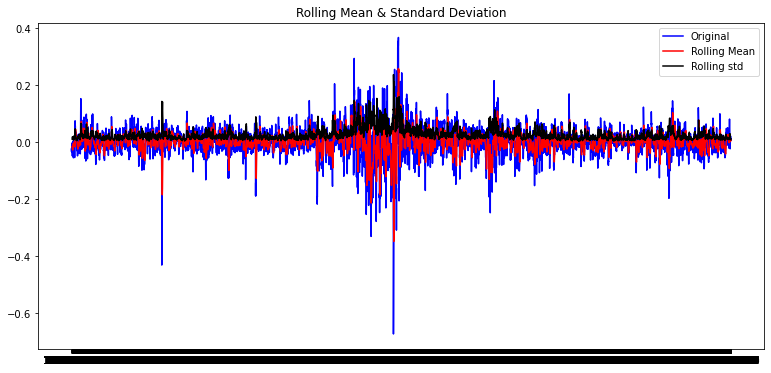

In [109]:
plot_rolling_statistics(ts_log_moving_avg)

In [110]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                -1.368958e+01
p-value                        1.351946e-25
#Lags Used                     3.900000e+01
Number of Observations Used    1.057900e+04
Critical Value (1%)           -3.430968e+00
Critical Value (5%)           -2.861813e+00
Critical Value (10%)          -2.566915e+00
dtype: float64


차분(Differencing) - 계절성(Seasonality) 상쇄하기

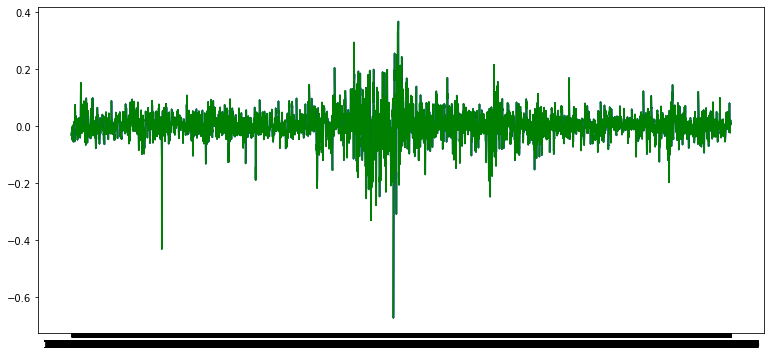

In [111]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

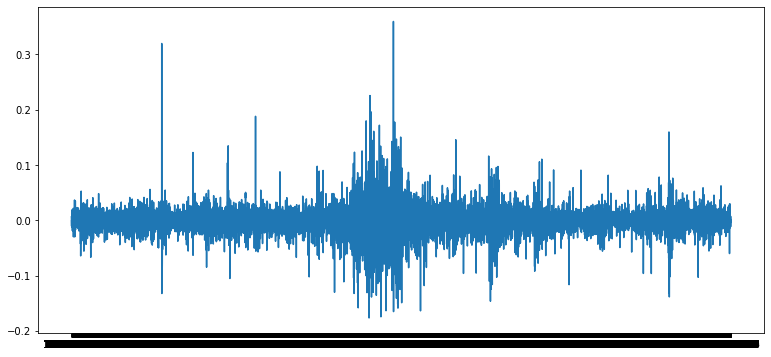

In [112]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

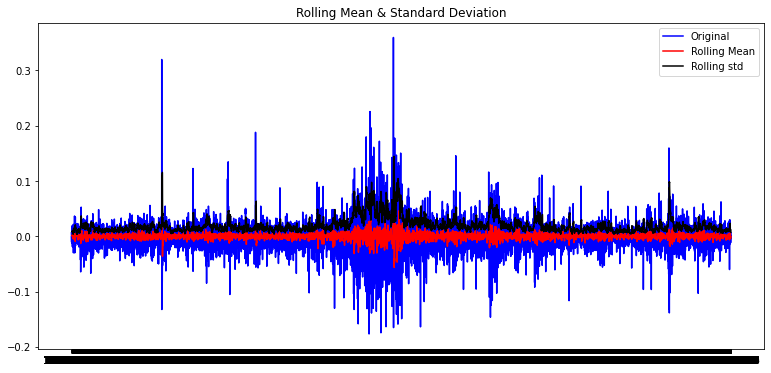

In [113]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [114]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey=Fuller Test:
Test Statistic                   -26.834852
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10578.000000
Critical Value (1%)               -3.430968
Critical Value (5%)               -2.861813
Critical Value (10%)              -2.566915
dtype: float64


In [ ]:

decomposition = seasonal_decompose(ts_log, model='additive', period = 30)
#시계열 데이터에 0 또는 음수 값이 있어서 발생한 오류이며, 이러한 값은 계절성을 곱하는 방법으로 분해할 수 없음


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)


In [ ]:
augmented_dickey_fuller_test(residual)

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

In [ ]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

In [ ]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

차분은 1차분으로해도 충분해 보임

In [ ]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

In [ ]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

학습 데이터 분리

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

In [ ]:
model = ARIMA(train_data, order=(2, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

In [ ]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [ ]:
model = ARIMA(train_data, order=(2, 1, 1))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

## 시스코


In [ ]:
import yfinance as yf

cisco = yf.Ticker('CSCO')  



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cisco_data = cisco.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
cisco_data.index = pd.to_datetime(cisco_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cisco_data,  columns=cisco_data.columns)

df


In [ ]:
ts = df['Close']
ts

In [ ]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

In [ ]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [ ]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [ ]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

계절성 추세 확인하기

In [ ]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

In [ ]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

In [ ]:
plot_rolling_statistics(ts_log_moving_avg)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg)

차분(Differencing) - 계절성(Seasonality) 상쇄하기

In [ ]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

In [ ]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

In [ ]:


decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [ ]:
augmented_dickey_fuller_test(residual)

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

In [ ]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [ ]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')
diff_3.plot(title='Difference 3rd')


In [ ]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

In [ ]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

In [ ]:
model = ARIMA(train_data, order=(5, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

In [ ]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

In [ ]:
model = ARIMA(train_data, order=(5, 1, 0))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

### 회고

- 야후 파이낸스에서 제공하는 데이터를 최대치를 넣어 모델을 테스트 해보니 흥미로웠습니다.
- 하지만 p, q 적절한 값을 찾기에는 어려움이 많았습니다.
- 시계열에 대해서 많은 공부가 필요하다는 것을 느꼈습니다.
- 예측, 학습 데이터에 대한 그래프를 그리는데 학습데이터 값에서 횡방향으로 그어지는 문제가 발생했는데
해결을 하지 못해서 조금 아쉽습니다.
- 더 다양한 데이터와 함께 학습을 한다면 조금 달라질 수 있겠지만, 주가를 예측하는 것은 어려워보인다
